In [148]:
# loading libraries 
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from os.path import join, dirname
import os 
from io import BytesIO

import seaborn_image as isns

def show_anns(anns):

    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker="*", color="green", marker_size=375, ):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color=color, marker=marker, s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker=marker, s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def apply_mask(np_image, mask, ax):
    res = cv2.bitwise_and(np_image,np_image,mask = mask)
    ax.imshow(res)

In [2]:
filepath = "../../data/20240109_155650751.jpg"
image = cv2.imread(filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

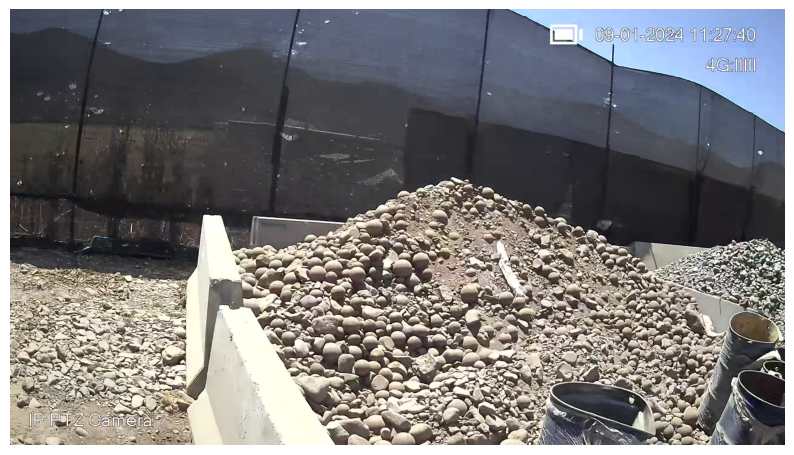

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH  = "/dagster/apps/dagster_easyscraptracker/dagster_easyscraptracker/models/sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

mask_predictor = SamPredictor(sam)

Select region of interest

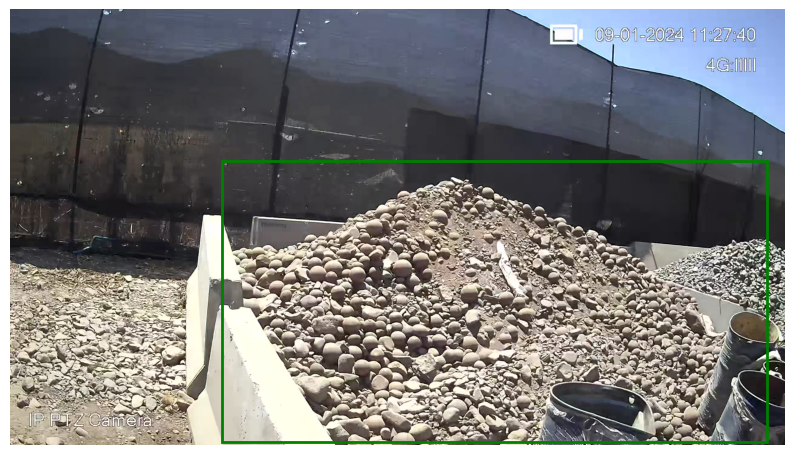

In [5]:
box = np.array([700, 500, 2500, 1430])

plt.figure(figsize=(10,10))
plt.imshow(image)
#x0, y0 = box[0], box[1]
#w, h = box[2] - box[0], box[3] - box[1]
# ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [6]:
mask_predictor.set_image(image)

In [7]:
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

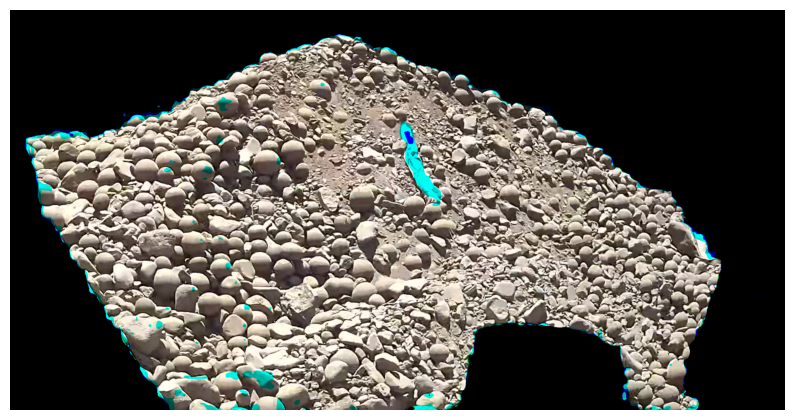

In [8]:
#input_box = np.array([700, 500, 2500, 1430])
x, y = box[0], box[1]
w, h = box[2] - box[0], box[3] - box[1]
result = image*np.transpose(masks, (1, 2, 0))
cropped_result = result[y:y+h, x:x+w]
plt.figure(figsize=(10, 10))
plt.imshow(cropped_result)
plt.axis('off')
plt.show()

second segmentation on region of interest

In [9]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [10]:
masks2 = mask_generator_2.generate(cropped_result)

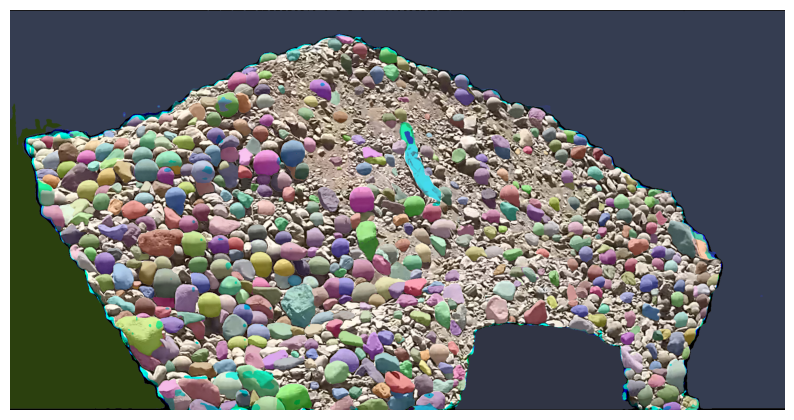

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(cropped_result)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [54]:
cropped_result.shape

(930, 1800, 3)

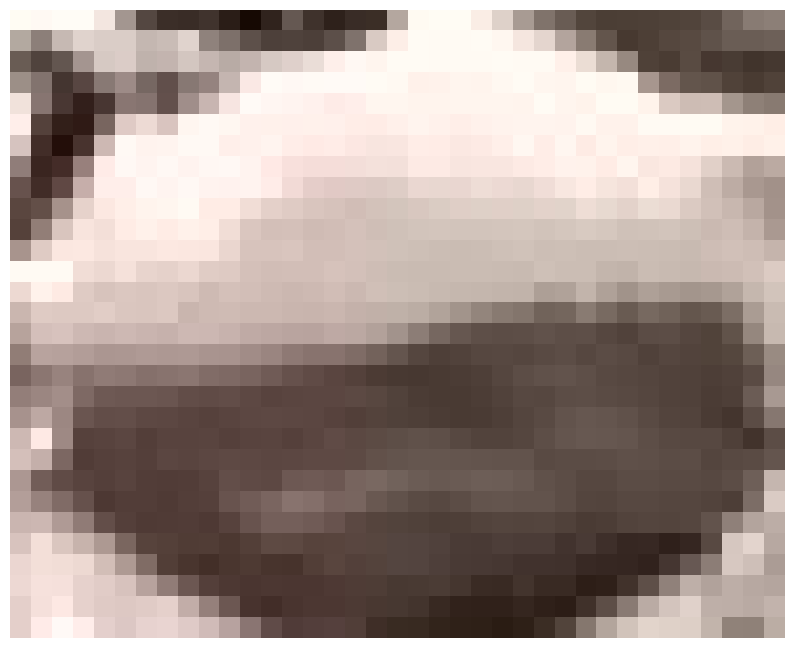

In [12]:
element = masks2[0]['bbox']
x, y, w, h = (e for e  in masks2[0]['bbox'])
img = cropped_result[y:(y+h), x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show() 

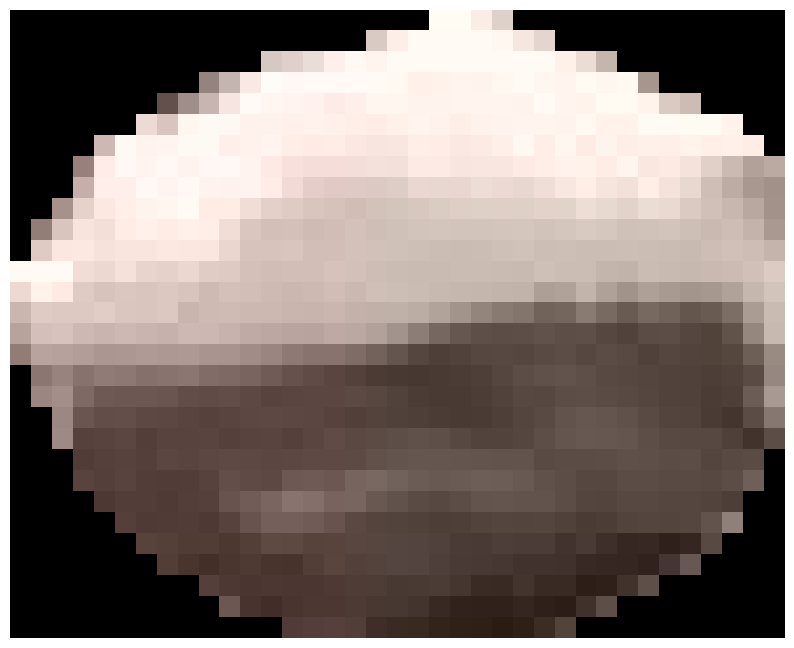

In [32]:
_mask = masks2[0]["segmentation"].reshape(930, 1800, 1)
x, y, w, h = (e for e  in masks2[0]['bbox'])
plt.figure(figsize=(10,10))
plt.imshow(_mask[y:(y+h), x:x+w] * cropped_result[y:(y+h), x:x+w])
plt.axis('off')
plt.show() 

In [81]:
cropped_result.shape

(930, 1800, 3)

In [119]:
def show_anns2(anns, image):
    if len(anns) == 0:
        return
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    rgba = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    return img and rgba


In [120]:
img2 = show_anns2(masks2, cropped_result)
plt.imshow(img2)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [99]:
img2.shape

(930, 1800, 4)

In [113]:
color_mask = np.concatenate([np.random.random(3), [0.35]])
color_mask

array([0.04081709, 0.8373556 , 0.27845847, 0.35      ])

In [142]:
from matplotlib import use as pltuse
pltuse('Agg')  # Configurar el backend para que no muestre gráficos de forma interactiva
# Crear un buffer de bytes para almacenar la imagen
buffer = BytesIO()

# Guardar la figura en el buffer
plt.figure(figsize=(10,10))
plt.imshow(cropped_result)
show_anns(masks2)
plt.savefig(buffer, format='png')
plt.axis('off')


(-0.5, 1799.5, 929.5, -0.5)

In [143]:
# Convertir bytes a matriz numpy

# Reiniciar el puntero de lectura al principio del buffer
buffer.seek(0)

# Leer los datos del buffer
imagen_bytes = buffer.getvalue()


In [144]:
imagen_bytes
# Convertir bytes a matriz numpy
imagen_numpy = plt.imread(BytesIO(imagen_bytes))

In [151]:
isns.imshow(imagen_numpy)


<Axes: >

In [83]:

data = dict()
data["year"] = 2024
data["day"]= 1
data["masks"] = [{"segmentation": [123,123,12,31,23], "mask_id":0}, {"segmentation": [123,123,122,313,232], "mask_id":1}]



In [84]:
data

{'year': 2024,
 'day': 1,
 'masks': [{'segmentation': [123, 123, 12, 31, 23], 'mask_id': 0},
  {'segmentation': [123, 123, 122, 313, 232], 'mask_id': 1}]}

In [79]:
import copy

In [85]:
datafull = copy.deepcopy(data)

In [86]:
datafull

{'year': 2024,
 'day': 1,
 'masks': [{'segmentation': [123, 123, 12, 31, 23], 'mask_id': 0},
  {'segmentation': [123, 123, 122, 313, 232], 'mask_id': 1}]}

In [87]:
for i, d in enumerate(data["masks"]):
    datafull["masks"][i]["mask_id"]=i+1
    data["masks"][i].pop("segmentation")

In [88]:
datafull

{'year': 2024,
 'day': 1,
 'masks': [{'segmentation': [123, 123, 12, 31, 23], 'mask_id': 1},
  {'segmentation': [123, 123, 122, 313, 232], 'mask_id': 2}]}

In [89]:
data

{'year': 2024, 'day': 1, 'masks': [{'mask_id': 0}, {'mask_id': 1}]}